In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image
import zipfile

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/50045 Information Retrieval/train_images (1).zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/50045 Information Retrieval/train_images")
zip_ref.close()

In [35]:
%ls

drive/  sample_data/


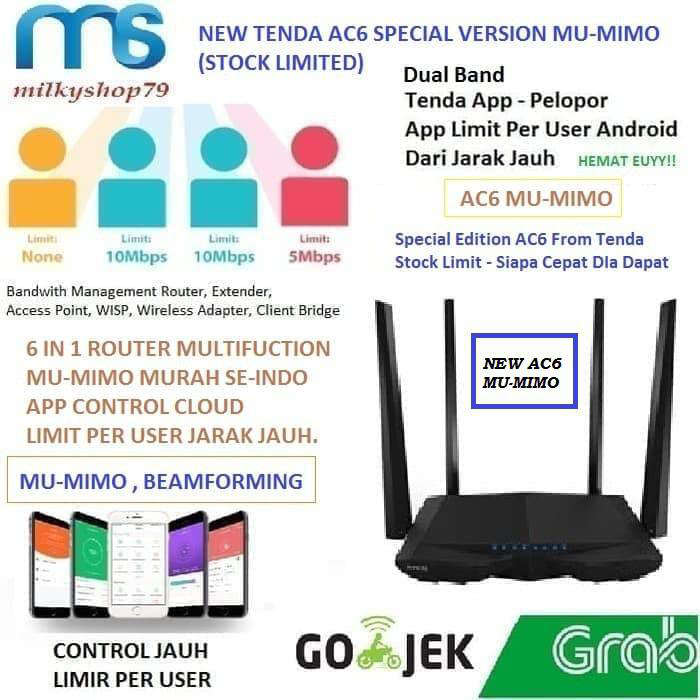

In [36]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends torchvision.datasets.ImageFolder
    """  
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

Image.open('/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/22c9ac783006b672e61cb704a4e44782.jpg')

In [37]:
#preprocess images
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

dataset = ImageFolderWithPaths('/content/drive/MyDrive/50045 Information Retrieval/train_images/', transforms_) # our custom dataset

#define dataloader
BATCH = 1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [10]:
model = models.alexnet(pretrained=True) #write your code here
model.to(DEVICE)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [11]:
def pooling_output(x):
	#write your code here
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x.view(BATCH, -1)

vec_img_list = []

In [38]:
with torch.no_grad():
    model.eval()
    for item, (inputs, labels, paths) in enumerate(dataloader):
        print("Batch {}/{}".format(item,len(dataloader)), end='\r')
        inputs = inputs.to(DEVICE)
        img_vec = pooling_output(inputs) #write your code here
        vec_img_list += [(img_vec.cpu(), paths[0])]
        torch.cuda.empty_cache()

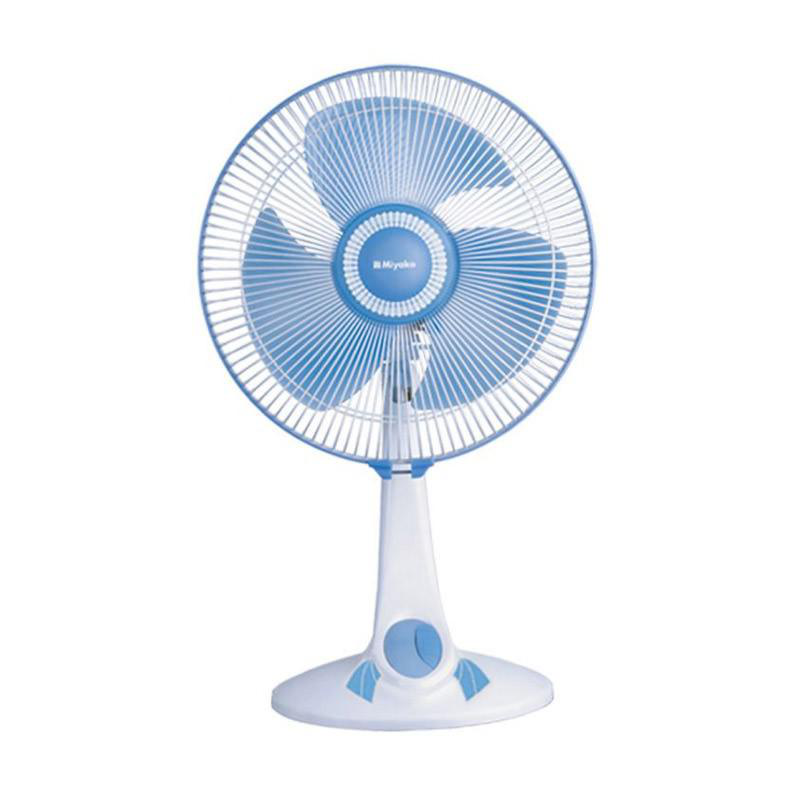

In [39]:
query_image = '/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/21fd77a5e19e95031e1aae48006f96c7.jpg'
img = Image.open(query_image)
Image.open(query_image) # Just to visualise

In [40]:
input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)

In [41]:
with torch.no_grad():
    input_tensor = input_tensor.to(DEVICE)
    query_vector = pooling_output(input_tensor)
    query_vector = query_vector.cpu()

query_vector = query_vector.reshape(1, 9216)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [42]:
N = 5
#write you code here
cos_sim_dict = {}
for i in vec_img_list:
    cos_sim_dict[i[1]] = cos(query_vector, i[0])

# print(cos_sim_dict)
cos_sim_dict_sorted = {k: v for k, v in sorted(cos_sim_dict.items(), key=lambda item: item[1])}
# print(cos_sim_dict_sorted)

final_ans = list(cos_sim_dict_sorted.keys())[-N-1:-1]
print(final_ans)

['/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/2143a39392f4710b74f37829a3546512.jpg', '/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/d49900205724e08018b719fabe953f8e.jpg', '/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/196de96131fe1643a674967a3c4065b0.jpg', '/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/1cd23c1d7246d93d6d1a8aaab00f03df.jpg', '/content/drive/MyDrive/50045 Information Retrieval/train_images/train_images/457909670eb28fa218a7c5e308521ebc.jpg']


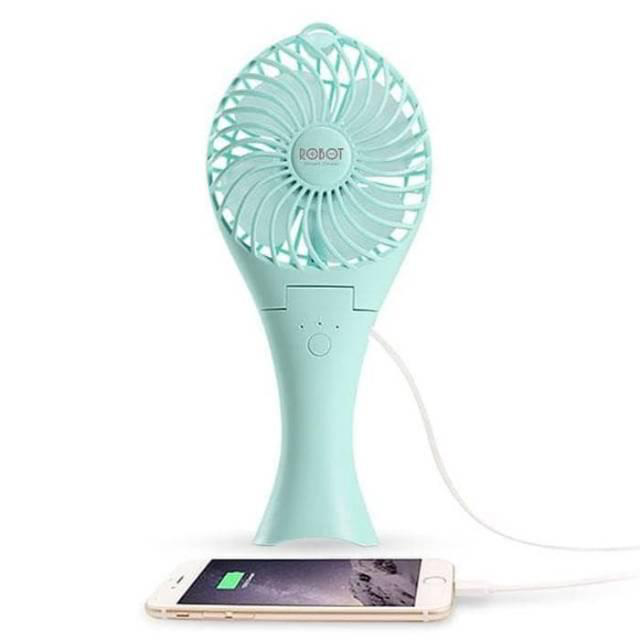

In [48]:
Image.open(final_ans[0])

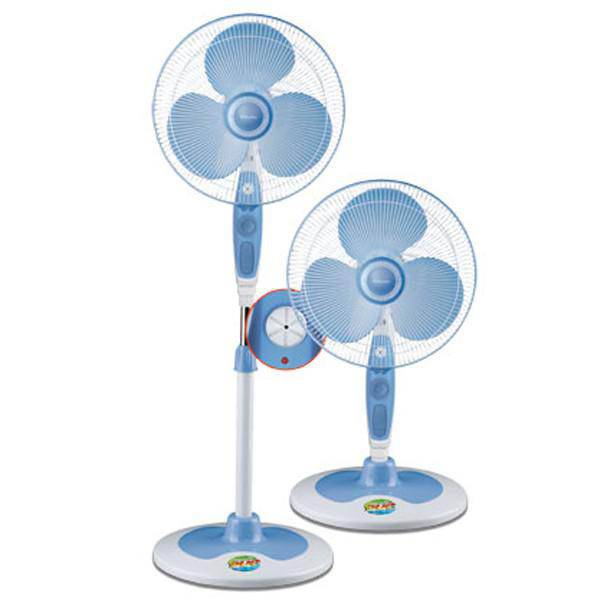

In [45]:
Image.open(final_ans[-2])